classification : 分類問題

In [1]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


フォルダは自分の指定のものに変更して下さい。

In [3]:
%cd "ctorch211122/MiniCTorch_Prototype/notebook"

/content/drive/My Drive/Colab Notebooks/ctorch211122/MiniCTorch_Prototype/notebook


ライブラリのimport

In [4]:
!pip install lark-parser

     |████████████████████████████████| 103 kB 9.3 MB/s 


In [5]:
import sys
sys.path.append("../")

import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import minictorch.generator as GN
import minictorch.converter as CV

In [6]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler

#from torch.utils.data import TensorDataset
#from torch.utils.data import DataLoader

データ読み込み

In [7]:
# データ読み込み
iris = datasets.load_iris()
data   = iris['data']
target = iris['target']

# 学習データと検証データに分割
x_train, x_valid, y_train, y_valid = train_test_split( data, target, shuffle=True )

# 特徴量の標準化
scaler = StandardScaler()
scaler.fit( x_train )

x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)

# Tensor型に変換
# 学習に入れるときはfloat型 or long型になっている必要があるのここで変換してしまう
x  = torch.from_numpy(x_train).float()
y  = torch.from_numpy(y_train).long()
vx = torch.from_numpy(x_valid).float()
vy = torch.from_numpy(y_valid).long()

print('x_train : ', x_train.shape)
print('y_train : ', y_train.shape)
print('x_valid : ', x_valid.shape)
print('y_valid : ', y_valid.shape)

x_train :  (112, 4)
y_train :  (112,)
x_valid :  (38, 4)
y_valid :  (38,)


DataSetとDataLoaderの生成

In [8]:
"""
train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)

# indexを指定すればデータを取り出すことができます。
index = 0
print( train_dataset.__getitem__(index)[0].size() )
print( train_dataset.__getitem__(index)[1] )


batch_size = 112
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# 動作確認
# こんな感じでバッチ単位で取り出す子ができます。
# イテレータに変換
batch_iterator = iter(train_dataloader)

# 1番目の要素を取り出す
inputs, labels = next(batch_iterator)
print(inputs.size())
print(labels.size())
print(inputs)
print(labels)
"""

'\ntrain_dataset = TensorDataset(x_train, y_train)\nvalid_dataset = TensorDataset(x_valid, y_valid)\n\n# indexを指定すればデータを取り出すことができます。\nindex = 0\nprint( train_dataset.__getitem__(index)[0].size() )\nprint( train_dataset.__getitem__(index)[1] )\n\n\nbatch_size = 112\ntrain_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)\nvalid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)\n\n# 動作確認\n# こんな感じでバッチ単位で取り出す子ができます。\n# イテレータに変換\nbatch_iterator = iter(train_dataloader)\n\n# 1番目の要素を取り出す\ninputs, labels = next(batch_iterator)\nprint(inputs.size())\nprint(labels.size())\nprint(inputs)\nprint(labels)\n'

トレーニング用のデータを生成する

In [9]:
batch_size = 16
print(x.shape)
print(y.shape)
inputs = x[0:batch_size,:]
labels = y[0:batch_size]

torch.Size([112, 4])
torch.Size([112])


ニューラルネットワークの定義

In [ ]:
"""
class Net(nn.Module):    
    def __init__(self,t):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        #self.drop1 = nn.Dropout(0.5) ### drop
        self.fc2 = nn.Linear(64, 3)
        self.target = t
    
    def forward(self, x):
        self.x1 = F.relu(self.fc1(x))
        #self.x2 = self.drop1(self.x1)  ## drop
        #x = self.fc2(self.x2)
        x = self.fc2(self.x1)
        #x = F.log_softmax(x, dim=1)
        #return x
        self.out = x

        loss = nn.CrossEntropyLoss()
        #loss = nn.NLLLoss()
        output = loss( x, self.target )
        return output
"""
class Model(torch.nn.Module):

  class Net( torch.nn.Module ):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 64)
        #self.drop1 = nn.Dropout(0.5) ### drop
        self.fc2 = nn.Linear(64, 3)
    
    def forward(self, x):
        self.x1 = F.relu(self.fc1(x))
        #self.x2 = self.drop1(self.x1)  ## drop
        #x = self.fc2(self.x2)
        x = self.fc2(self.x1)
        return x

  class Loss( torch.nn.Module ):
    def __init__( self ):
      super().__init__()
      print("create loss class")

    def forward(self,y,t):
      loss = nn.CrossEntropyLoss()
      #loss = nn.NLLLoss()
      output = loss( y, t )
      return output

  def __init__( self, t ):
    super( Model, self ).__init__()
    print("create model class")
    self.net  = self.Net()
    self.loss = self.Loss()
    self.target = t

  def forward( self, x ):
    self.out = self.net( x )
    out = self.loss( self.out, self.target )
    return out

プロジェクト名、作業フォルダ、JSONファイル名の設定

In [ ]:
project = 'clas'
folder = './classification'
json_path = folder + '/' + project +'.json'

計算グラフをJSONファイルに出力する

In [ ]:
def generate_json( json_path, input, target ):

    model = Model( target )
    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        GN.generate_minictorch_file( model, input, json_path )

    return model

In [ ]:
torch.manual_seed( 1 )

inputs.requires_grad = True

model = generate_json( json_path, inputs, labels )

create model class
create loss class
[SAVE] ./classification/clas.json
skip: Model/Net[net]/Linear[fc1]/weight/fc1
skip: Model/Net[net]/Linear[fc1]/weight/fc1
skip: Model/Net[net]/Linear[fc2]/weight/fc2
skip: Model/Net[net]/Linear[fc2]/weight/fc2


一回の順伝播、逆伝播のC++コードを生成する

In [ ]:
CV.convert_cpp_code( project, folder, model, inputs, json_path )

[JSON] ./classification/clas.json
{'name': 'Model/Net[net]/Linear[fc1]/weight/weight.5', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 1}
{'name': 'Model/Net[net]/Linear[fc1]/bias/bias.5', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 2}
{'name': 'Model/Net[net]/Linear[fc2]/weight/weight', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 5}
{'name': 'Model/Net[net]/Linear[fc2]/bias/bias', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 6}
[PARAM] ./classification/clas_param.cpp
{'name': 'input/x', 'op': 'IO Node', 'in': [], 'output_id': 0, 'shape': [16, 4], 'out': [3], 'sorted_id': 0}
{'name': 'Model/Net[net]/Linear[fc1]/weight/weight.5', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 1}
Model/Net[net]/Linear[fc1]/weight/weight.5  ->  fc1_weight
{'name': 'Model/Net[net]/Linear[fc1]/bias/bia

In [ ]:
#check code
with torch.set_grad_enabled(True):

  output = model( inputs )
  print("output",output)

  model.zero_grad()
  output.backward()
  print("output grad",output.grad)
  print("input grad",inputs.grad)

  # ラベルを予測
  preds = torch.argmax( model.out, dim=1 )

  # イテレーション結果の計算
  epoch_loss = output * inputs.size(0)

  # 正解数の合計を更新
  epoch_corrects = torch.sum( preds == labels.data )

  epoch_loss = epoch_loss / float(inputs.size(0))
  epoch_acc  = epoch_corrects.double() / float(inputs.size(0))

  epoch=1
  print('Train Loss {}: {:.4f} Acc: {:.4f}'.format( epoch, epoch_loss, epoch_acc ))

output tensor(1.1193, grad_fn=<NllLossBackward0>)
output grad None
input grad tensor([[ 2.4536e-03,  6.5992e-03, -3.6665e-04,  5.7500e-03],
        [-8.0744e-03, -2.8593e-03,  2.3982e-03, -3.3772e-03],
        [ 4.9122e-03, -9.5054e-03, -4.3834e-03, -3.1405e-03],
        [-1.4668e-03, -2.8611e-03, -3.2994e-04, -1.1482e-02],
        [ 8.4284e-03,  6.3636e-03, -3.0588e-03,  5.1139e-03],
        [ 2.4434e-03,  6.2667e-03, -2.0942e-03,  4.2317e-03],
        [ 8.0078e-03,  7.1667e-03, -9.2503e-03,  5.3157e-03],
        [-8.8882e-03, -3.8847e-03,  2.7739e-03, -2.2468e-03],
        [ 1.5007e-03,  7.1385e-03,  1.3187e-04,  4.8217e-03],
        [ 4.9054e-03,  1.5965e-03,  8.4382e-03, -4.4428e-03],
        [-9.3159e-03,  4.4378e-06,  5.3714e-05,  2.0491e-03],
        [-1.7574e-03, -2.6599e-03,  1.6963e-03, -1.0683e-02],
        [-4.8088e-03, -2.0256e-03, -3.6220e-03, -7.7088e-03],
        [-1.8583e-03,  6.5698e-03,  4.3756e-04,  9.1248e-04],
        [ 6.3851e-03, -9.4419e-03,  4.9090e-03, -5.255

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


C++コードをコンパイルする

In [ ]:
!g++ -std=c++14 ./classification/clas.cpp ./classification/clas_param.cpp -D_NOTEBOOK -I ../../../xtensor -lcblas -o ./classification/clas

(注) xtensorフォルダにxtensor関連のincludeファイルを置いています。各自の環境に合わせて変更して下さい。

In [ ]:
!./classification/clas

### forward computation ...
 1.119286
### backward computation ...
input_grad{{ 0.002454,  0.006599, -0.000367,  0.00575 },
 {-0.008074, -0.002859,  0.002398, -0.003377},
 { 0.004912, -0.009505, -0.004383, -0.003141},
 {-0.001467, -0.002861, -0.00033 , -0.011482},
 { 0.008428,  0.006364, -0.003059,  0.005114},
 { 0.002443,  0.006267, -0.002094,  0.004232},
 { 0.008008,  0.007167, -0.00925 ,  0.005316},
 {-0.008888, -0.003885,  0.002774, -0.002247},
 { 0.001501,  0.007139,  0.000132,  0.004822},
 { 0.004905,  0.001596,  0.008438, -0.004443},
 {-0.009316,  0.000004,  0.000054,  0.002049},
 {-0.001757, -0.00266 ,  0.001696, -0.010683},
 {-0.004809, -0.002026, -0.003622, -0.007709},
 {-0.001858,  0.00657 ,  0.000438,  0.000912},
 { 0.006385, -0.009442,  0.004909, -0.005255},
 {-0.010103,  0.002207,  0.002543,  0.002432}}


学習の実行(python版)

In [ ]:
torch.manual_seed( 1 )

#inputs.requires_grad = True
model = Model( labels )

lr = 0.01
opt = torch.optim.SGD( model.parameters(), lr)

epochs = 200
batch_size = 16

num_train = len(x_train)
n_batch = num_train // batch_size  # 1エポックあたりのバッチ数
print("batch",n_batch,len(x_train),batch_size)

epoch_loss = []
epoch_acc = []
for epoch in range(epochs):
    
    # -- 学習 -- 
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)  # インデックスをシャッフルする

    model.train()   # モデルを訓練モードに設定

    total_loss = 0.0
    total_corrects = 0
    for j in range(n_batch):
        
        # ミニバッチを取り出す
        mb_index = index_random[ j*batch_size : (j+1)*batch_size ]
        inputs = x[mb_index, :]
        labels = y[mb_index]
       
        # 順伝播と逆伝播
        model.target = labels
        loss = model( inputs )
        total_loss += loss;

        # 正解数の合計を更新
        #_, preds = torch.max( model.out, 1 )
        preds = torch.argmax( model.out, dim=1 )
        num = torch.sum( preds == labels )
        total_corrects += num

        opt.zero_grad()
        loss.backward()
        opt.step()

    total_acc  = total_corrects.double() / float(num_train)
    print('Train Loss {}: {:.4f} Acc: {:.4f} {}'.format( epoch, total_loss, total_acc, total_corrects ))

    epoch_loss.append( total_loss )
    epoch_acc.append( total_acc )

create model class
create loss class
batch 7 112 16
Train Loss 0: 7.6317 Acc: 0.1786 20
Train Loss 1: 6.7156 Acc: 0.3839 43
Train Loss 2: 6.0363 Acc: 0.6607 74
Train Loss 3: 5.5251 Acc: 0.6875 77
Train Loss 4: 5.1235 Acc: 0.7143 80
Train Loss 5: 4.8032 Acc: 0.7321 82
Train Loss 6: 4.5482 Acc: 0.7500 84
Train Loss 7: 4.3303 Acc: 0.7857 88
Train Loss 8: 4.1459 Acc: 0.8036 90
Train Loss 9: 3.9829 Acc: 0.8125 91
Train Loss 10: 3.8414 Acc: 0.8393 94
Train Loss 11: 3.7132 Acc: 0.8482 95
Train Loss 12: 3.5999 Acc: 0.8571 96
Train Loss 13: 3.5023 Acc: 0.8571 96
Train Loss 14: 3.4064 Acc: 0.8571 96
Train Loss 15: 3.3203 Acc: 0.8571 96
Train Loss 16: 3.2351 Acc: 0.8571 96
Train Loss 17: 3.1575 Acc: 0.8661 97
Train Loss 18: 3.0853 Acc: 0.8750 98
Train Loss 19: 3.0208 Acc: 0.9018 101
Train Loss 20: 2.9599 Acc: 0.9018 101
Train Loss 21: 2.9050 Acc: 0.9018 101
Train Loss 22: 2.8500 Acc: 0.9018 101
Train Loss 23: 2.8002 Acc: 0.9018 101
Train Loss 24: 2.7480 Acc: 0.9107 102
Train Loss 25: 2.7054 Acc: 

収束状況グラフを描画する

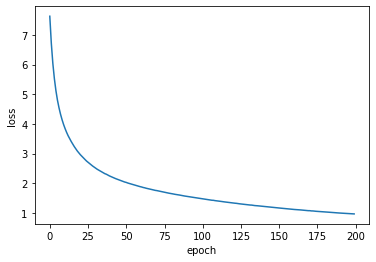

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.show()

正解率を描画する

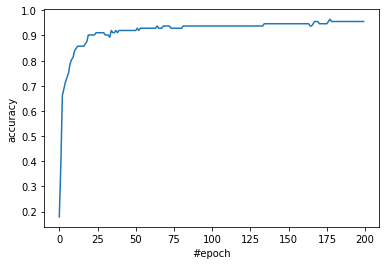

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_acc))),epoch_acc )
ax.set_xlabel('#epoch')
ax.set_ylabel('accuracy')
fig.show()

学習用データファイル、学習ループのC++コードを生成する

In [ ]:
CV.convert_data_file( project, folder, inp_data=x_train, target_data=y_train )
CV.convert_train_code( project, folder, json_path, sol="classification", batch=batch_size, inp_data=x_train, target_data=y_train )

datafile key :  inp_data
datafile key :  target_data
[DATA] ./classification/clas_data.cpp
[JSON] ./classification/clas.json
epoch_num :  200
batch_size :  16
lr :  0.01
inp  shape :  1 {112,4}
inp2 shape :  0 
target shape :  1 {112}
pred_num :  112
div :  False
pred_pos :  8 8 8
el  0 1  :  input/x IO Node [] 0 -1
el  3 1  :  Model/Net[net]/Linear[fc1]/input.1 aten::linear [0, 1, 2] 0 -1
el  4 1  :  Model/Net[net]/input.3 aten::relu [3] 0 -1
el  7 1  :  Model/Net[net]/Linear[fc2]/input aten::linear [4, 5, 6] 0 -1
el  13 1  :  Model/Loss[loss]/61 aten::cross_entropy_loss [7, 8, 9, 10, 11, 12] 0 -1
 --- pred el ( 0 ) : 7  ->  7
loss pred_id :  13 7
eval no : 13  (type= 2 ) :  7 8
last cmd: 13
------
solution : classification
pred_no   : 7
target_no : 8
class_no  : 8
pred_no :  7
[TRAIN]  ./classification/clas_train.cpp


学習用C++コードをコンパイル、リンクする

In [ ]:
!g++ -std=c++14 ./classification/clas_train.cpp ./classification/clas_param.cpp ./classification/clas.cpp ./classification/clas_data.cpp -D_NOTEBOOK -D_TRAIN -I ../../../xtensor -lcblas -o ./classification/clas_train

In [ ]:
! ./classification/clas_train

epoch_num : 200
indata shape   : 112,4
batch  number  : 7,16
learning ratio : 0.01
total_loss : epoch 0 : loss 7.62997 : Acc 0.232143 26
total_loss : epoch 0 : loss 1.00726 : Acc 0.232143 26
total_loss : epoch 1 : loss 6.72034 : Acc 0.375 42
total_loss : epoch 1 : loss 0.898054 : Acc 0.598214 67
total_loss : epoch 2 : loss 6.04665 : Acc 0.660714 74
total_loss : epoch 2 : loss 0.815721 : Acc 0.6875 77
total_loss : epoch 3 : loss 5.52863 : Acc 0.696429 78
total_loss : epoch 3 : loss 0.752557 : Acc 0.714286 80
total_loss : epoch 4 : loss 5.12167 : Acc 0.723214 81
total_loss : epoch 4 : loss 0.703121 : Acc 0.732143 82
total_loss : epoch 5 : loss 4.80373 : Acc 0.741071 83
total_loss : epoch 5 : loss 0.663102 : Acc 0.75 84
total_loss : epoch 6 : loss 4.54477 : Acc 0.75 84
total_loss : epoch 6 : loss 0.630015 : Acc 0.75 84
total_loss : epoch 7 : loss 4.33067 : Acc 0.776786 87
total_loss : epoch 7 : loss 0.601969 : Acc 0.794643 89
total_loss : epoch 8 : loss 4.14912 : Acc 0.8125 91
total_loss 

In [ ]:
# read output file from c++ code
path = folder + '/' + project + '.out'
f = open( path, 'r')

loss = []
acc=[]

datalist = f.readlines()
for data in datalist:
  #print(data)
  ds = data.split(',')
  loss.append( float(ds[0]) )
  acc.append( float(ds[1]) )

f.close()

print("epoch =", len(loss))
print( loss )
print(acc)

epoch = 200
[1.007255, 0.898054, 0.815721, 0.752557, 0.703121, 0.663102, 0.630015, 0.601969, 0.577703, 0.55643, 0.537482, 0.520464, 0.50505, 0.490955, 0.478021, 0.466082, 0.454995, 0.4447, 0.435079, 0.426091, 0.417641, 0.409708, 0.402224, 0.39516, 0.388467, 0.382126, 0.376109, 0.37038, 0.364937, 0.359738, 0.354779, 0.350042, 0.345508, 0.341163, 0.336998, 0.333001, 0.329152, 0.325451, 0.321885, 0.318448, 0.315132, 0.311927, 0.308827, 0.305824, 0.302917, 0.300095, 0.297355, 0.294693, 0.292105, 0.289586, 0.287136, 0.284752, 0.282434, 0.280176, 0.277969, 0.275806, 0.273697, 0.271631, 0.269609, 0.267632, 0.265693, 0.263793, 0.261935, 0.260113, 0.25833, 0.256582, 0.254866, 0.253181, 0.251527, 0.249899, 0.248299, 0.246725, 0.245176, 0.243652, 0.242149, 0.240673, 0.239216, 0.237781, 0.236366, 0.234968, 0.23359, 0.232227, 0.230881, 0.229552, 0.228242, 0.226948, 0.225667, 0.224401, 0.223147, 0.221907, 0.220684, 0.219467, 0.218268, 0.217082, 0.21591, 0.214751, 0.213602, 0.21247, 0.211348, 0.21023

収束状況グラフを描画する

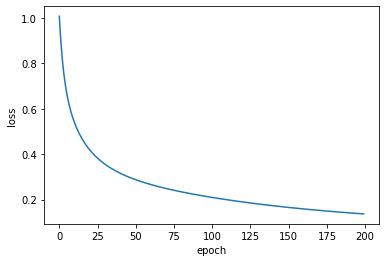

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(loss))), loss)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.show()

正解率を描画する

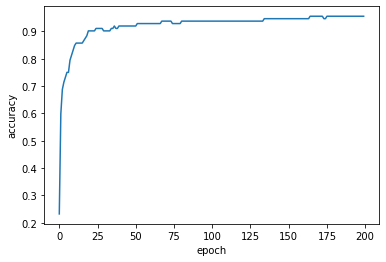

In [ ]:
# 正解率
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(acc))), acc)
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
fig.show()